**Exploring and Denoising Data**Notice: This notebook is a modification of
[sniff.ipynb](https://mlbook.explained.ai/notebooks/index.html) 
by Terence Parr and Jeremy Howard. It is being used by permission of the author.**


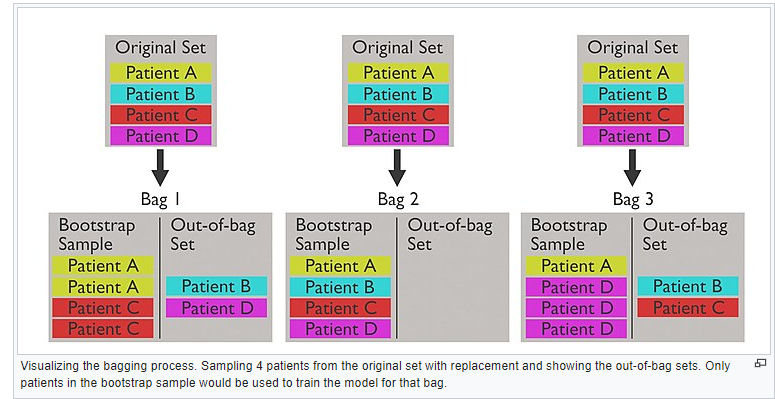

## 1. Building an Initial Model

#### Take a Quick Peek at the Data

In [1]:
import pandas as pd

In [2]:
rent = pd.read_csv('rent.csv')
rent.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"['Dining Room', 'Pre-War', 'Laundry in Buildin...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,['https://photos.renthop.com/2/7170325_3bb5ac8...,2400,145 Borinquen Place,medium
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"['Doorman', 'Elevator', 'Laundry in Building',...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,['https://photos.renthop.com/2/7092344_7663c19...,3800,230 East 44th,low
2,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"['Doorman', 'Elevator', 'Laundry in Building',...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,['https://photos.renthop.com/2/7158677_c897a13...,3495,405 East 56th Street,medium


In [3]:
rent.head(3).T

,0,1,2
bathrooms,1.0,1.0,1.0
bedrooms,1,2,2
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712,cd759a988b8f23924b5a2058d5ab2b49
created,2016-06-16 05:55:27,2016-06-01 05:44:33,2016-06-14 15:19:59
description,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...
display_address,145 Borinquen Place,East 44th,East 56th Street
features,"['Dining Room', 'Pre-War', 'Laundry in Buildin...","['Doorman', 'Elevator', 'Laundry in Building',...","['Doorman', 'Elevator', 'Laundry in Building',..."
latitude,40.7108,40.7513,40.7575
listing_id,7170325,7092344,7158677
longitude,-73.9539,-73.9722,-73.9625


In [4]:
rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      47906 non-null  object 
 5   display_address  49217 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49342 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 5.6+ MB


#### Select Only the Numeric Columns

In [5]:
rent.shape

(49352, 15)

In [62]:
rent_num = rent[['bathrooms', 'bedrooms', 'longitude', 'latitude', 'price']]

rent_num.head(3)

,bathrooms,bedrooms,longitude,latitude,price
0,1.00,1,-73.95,40.71,2400
1,1.00,2,-73.97,40.75,3800
2,1.00,2,-73.96,40.76,3495


In [63]:
rent_num.isnull().any()

bathrooms    False
bedrooms     False
longitude    False
latitude     False
price        False
dtype: bool

#### Create and Evaluate a Model

In [64]:
X = rent_num.drop('price', axis=1)
y = rent_num['price']

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

In [66]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)  

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True) 

rf.fit(X_train, y_train) 

rf.score(X_train, y_train)

0.8259901223581063

In [67]:
rf.oob_score_

-0.16352496955594065

In [68]:
rf.score(X_val, y_val)

0.8355221035672082

In [69]:
len(y_val)

9871

In [70]:
len(y_train)

39481

In [71]:
#price of 80% data - take the mean of those prices (np)
print(np.mean(y_train))


3847.3823864643755


In [72]:
avg_preds = [np.mean(y_train)] * len(y_val)

In [73]:
avg_preds

[3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864643755,
 3847.3823864

In [74]:
len (avg_preds)

9871

In [75]:
r2_score(y_val, avg_preds) 

-6.136371018583553e-05

In [76]:
train_r2 = []
train_mae = []
val_r2 = []
val_mae = []
oob_scores = []

for i in range(10):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True) 
    rf.fit(X_train, y_train)
    train_preds = rf.predict(X_train)
    val_preds = rf.predict(X_val)
    train_r2.append(round(r2_score(y_train, train_preds), 2))
    val_r2.append(round(r2_score(y_val, val_preds), 2))
    train_mae.append(round(mean_absolute_error(y_train, train_preds), 0))
    val_mae.append(round(mean_absolute_error(y_val, val_preds), 0))
    oob_scores.append(rf.oob_score_)

In [77]:
print("Train r2 scores: \n", train_r2)
print("")
print("Validation r2 scores: \n", val_r2)
print("")
print("Train MAE scores: \n", train_mae)
print("")
print("Validation MAE scores: \n", val_mae)
print("")
print("Out-of-bag scores: \n", oob_scores)

Train r2 scores: 
 [0.81, 0.93, 0.89, 0.89, 0.85, 0.9, 0.81, 0.89, 0.85, 0.81]

Validation r2 scores: 
 [0.57, 0.0, -0.92, -188.12, -61.93, -1.21, -3.06, -1.97, 0.66, 0.67]

Train MAE scores: 
 [318.0, 249.0, 305.0, 287.0, 310.0, 295.0, 331.0, 286.0, 319.0, 321.0]

Validation MAE scores: 
 [381.0, 843.0, 451.0, 901.0, 578.0, 593.0, 439.0, 647.0, 384.0, 372.0]

Out-of-bag scores: 
 [-0.05859463067167847, 0.5242346881564375, -0.18555641277634138, 0.07566665181609677, -0.15337772034374475, -0.1731834230065019, -0.26552458048921945, -0.22434349123043984, -0.1545495299271602, -0.15499187263753322]


In [78]:
print("Mean train r2: ", np.mean(train_r2))
print("Mean validation r2: ", np.mean(val_r2))
print("Mean train MAE: ", np.mean(train_mae))
print("Mean validation MAE: ", np.mean(val_mae))
print("Mean oob score: ", np.mean(oob_scores))

Mean train r2:  0.8630000000000001
Mean validation r2:  -25.531
Mean train MAE:  302.1
Mean validation MAE:  558.9
Mean oob score:  -0.0770220321110085


Given the strength of RFs, poor performance could indicate there is little to no relationship to capture between apartment characteristics and rent price, or it could mean the data is inconsistent or has outliers. The variability of the hold out validation error hints that the data is inconsistent or has outliers, so let's take another look at the data set.


## 2. Denoise the Data
We're going to explore the data with the explicit purpose of finding anomalies. The focus of our model is on typically-priced apartments and only within New York City proper, which means we're going to look for extreme rent values and apartments outside of New York City.

In [79]:
pd.options.display.float_format = '{:20,.2f}'.format

In [80]:
rent_num.describe()

,bathrooms,bedrooms,longitude,latitude,price
count,"49,352.00","49,352.00","49,352.00","49,352.00","49,352.00"
mean,1.21,1.54,-73.96,40.74,"3,830.17"
std,0.50,1.12,1.18,0.64,"22,066.87"
min,0.00,0.00,-118.27,0.00,43.00
25%,1.00,1.00,-73.99,40.73,"2,500.00"
50%,1.00,1.00,-73.98,40.75,"3,150.00"
75%,1.00,2.00,-73.95,40.77,"4,100.00"
max,10.00,8.00,0.00,44.88,"4,490,000.00"


In [81]:
rent_num['price'].sort_values(ascending=False).to_frame().head(10) 

,price
12947,4490000
4793,1150000
22968,1070000
22058,1070000
49289,135000
1830,111111
36476,100000
21525,90000
46382,85000
38564,80000


In [82]:
rent_num['bathrooms'].value_counts().to_frame()

,bathrooms
1.00,39422
2.00,7660
3.00,745
1.50,645
0.00,313
2.50,277
4.00,159
3.50,70
4.50,29
5.00,20


In [83]:
rent_num['bedrooms'].value_counts().to_frame()

,bedrooms
1,15752
2,14623
0,9475
3,7276
4,1929
5,247
6,46
8,2
7,2


#### Noise

In [84]:
rent_num[(rent_num['longitude'] == 0.0) & (rent_num['latitude'] == 0.0)]

,bathrooms,bedrooms,longitude,latitude,price
829,1.00,1,0.00,0.00,1750
14891,1.00,1,0.00,0.00,1725
15568,1.00,2,0.00,0.00,4395
18623,1.00,2,0.00,0.00,2950
19807,1.00,2,0.00,0.00,3619
25317,4.00,3,0.00,0.00,16500
26304,1.00,1,0.00,0.00,3600
27595,1.00,2,0.00,0.00,3200
28153,1.00,1,0.00,0.00,3495
30640,1.00,2,0.00,0.00,3200


In [85]:
rent_num[(rent_num['longitude'] < -80)]

,bathrooms,bedrooms,longitude,latitude,price
15835,1.00,1,-118.27,34.01,2425
29012,1.00,0,-87.61,41.75,2000
31263,3.00,3,-93.27,44.88,13875
41722,1.00,0,-86.15,39.84,2650


#### Inconsistencies

In [86]:
rent_num[(rent_num['latitude'] > 40.728) & (rent_num['latitude'] < 40.733) &
         (rent_num['longitude'] >= -74.011) & (rent_num['longitude'] <= -74.007) &
         (rent_num['bedrooms'] == 2) & 
         (rent_num['bathrooms'] == 1)]

,bathrooms,bedrooms,longitude,latitude,price
8048,1.00,2,-74.01,40.73,3350
12947,1.00,2,-74.01,40.73,4490000
49012,1.00,2,-74.01,40.73,6397


#### Cleaning up the price

In [87]:
rent_clean = rent_num[(rent_num['price'] > 1000) & (rent_num['price'] < 10000)]

Text(0, 0.5, 'Num Apts at that price')

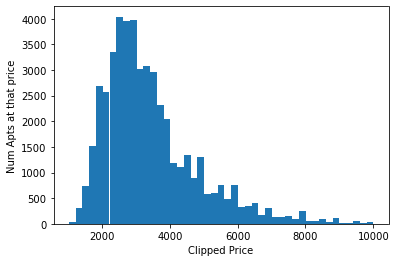

In [88]:
import matplotlib.pyplot as plt

plt.hist(rent_clean['price'], bins=45)
plt.xlabel('Clipped Price')
plt.ylabel('Num Apts at that price')

#### Cleaning up the location

In [89]:
rent_clean = rent_clean[(rent_clean['longitude'] !=0) | (rent_clean['latitude']!=0)]

In [90]:
rent_clean = rent_clean[(rent_clean['latitude']>40.55) &
                        (rent_clean['latitude']<40.94) &
                        (rent_clean['longitude']>-74.1) &
                        (rent_clean['longitude']<-73.67)]

#### Check Impact on Number of Samples

In [91]:
rent_num.shape

(49352, 5)

In [92]:
rent_clean.shape

(48300, 5)

In [93]:
(rent_num.shape[0] - rent_clean.shape[0]) / rent_num.shape[0]

0.021316258712919436

#### Train Model on Denoised Data

In [94]:
X_clean = rent_clean.drop('price', axis=1)
y_clean = rent_clean['price']

In [95]:
X_clean_train, X_clean_val, y_clean_train, y_clean_val = train_test_split(X_clean, y_clean, test_size=0.2)  

rf_clean = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True) 

rf_clean.fit(X_clean_train, y_clean_train) 

rf_clean.score(X_clean_train, y_clean_train)

0.9468684754000971

In [96]:
rf_clean.oob_score_

0.8577877813054573

In [97]:
rf_clean.score(X_clean_val, y_clean_val)

0.8650506706436936

In [98]:
train_r2 = []
train_mae = []
val_r2 = []
val_mae = []
oob_scores = []

for i in range(10):
    X_clean_train, X_clean_val, y_clean_train, y_clean_val = train_test_split(X_clean, y_clean, test_size=0.2)
    rf_clean = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True) 
    rf_clean.fit(X_clean_train, y_clean_train)
    train_preds = rf_clean.predict(X_clean_train)
    val_preds = rf_clean.predict(X_clean_val)
    train_r2.append(round(r2_score(y_clean_train, train_preds), 4))
    val_r2.append(round(r2_score(y_clean_val, val_preds), 4))
    train_mae.append(round(mean_absolute_error(y_clean_train, train_preds), 0))
    val_mae.append(round(mean_absolute_error(y_clean_val, val_preds), 0))
    oob_scores.append(round(rf_clean.oob_score_, 4))


In [99]:
print("After cleaning: \n")
print("Train r2 scores: \n", train_r2)
print("")
print("Validation r2 scores: \n", val_r2)
print("")
print("Train MAE scores: \n", train_mae)
print("")
print("Validation MAE scores: \n", val_mae)

After cleaning: 

Train r2 scores: 
 [0.9479, 0.948, 0.9463, 0.9463, 0.9485, 0.9468, 0.9466, 0.947, 0.9471, 0.9498]

Validation r2 scores: 
 [0.8564, 0.8549, 0.8684, 0.8687, 0.8575, 0.8666, 0.8623, 0.8632, 0.8636, 0.8427]

Train MAE scores: 
 [185.0, 185.0, 186.0, 187.0, 184.0, 186.0, 186.0, 185.0, 186.0, 183.0]

Validation MAE scores: 
 [296.0, 296.0, 289.0, 285.0, 296.0, 289.0, 289.0, 295.0, 291.0, 300.0]


In [100]:
print("Mean train r2: ", round(np.mean(train_r2), 4))
print("Mean validation r2: ", round(np.mean(val_r2), 4))
print("Mean train MAE: ", round(np.mean(train_mae), 0))
print("Mean validation MAE: ", round(np.mean(val_mae), 0))

Mean train r2:  0.9474
Mean validation r2:  0.8604
Mean train MAE:  185.0
Mean validation MAE:  293.0


## 3. Data Transformations

In [101]:
top_ten_orig = rent_num['price'].sort_values(ascending=False).head(10).reset_index()['price']
bottom_ten_orig = rent_num['price'].sort_values(ascending=False).tail(10).reset_index()['price']

pd.DataFrame({'Top 10 prices': top_ten_orig, 'Lowest 10 prices': bottom_ten_orig}) 

,Top 10 prices,Lowest 10 prices
0,4490000,868
1,1150000,800
2,1070000,700
3,1070000,695
4,135000,695
5,111111,695
6,100000,695
7,90000,401
8,85000,45
9,80000,43


The ratio of the highest to lowest price:

In [102]:
4490000 / 43

104418.6046511628

In [103]:
top_ten_log = np.log(rent_num['price'].sort_values(ascending=False).head(10).reset_index()['price'])
bottom_ten_log = np.log(rent_num['price'].sort_values(ascending=False).tail(10).reset_index()['price'])

pd.DataFrame({'Top 10 log(prices)': top_ten_log, 'Lowest 10 log(prices)': bottom_ten_log})

,Top 10 log(prices),Lowest 10 log(prices)
0,15.32,6.77
1,13.96,6.68
2,13.88,6.55
3,13.88,6.54
4,11.81,6.54
5,11.62,6.54
6,11.51,6.54
7,11.41,5.99
8,11.35,3.81
9,11.29,3.76


The ratio of the highest to lowest `log(price)`:

In [104]:
15.317363 / 3.7612

4.072467031798362

In [105]:
inconsistent_prices = rent_num[(rent_num['latitude'] > 40.728) & (rent_num['latitude'] < 40.733) &
         (rent_num['longitude'] >= -74.011) & (rent_num['longitude'] <= -74.007) &
         (rent_num['bedrooms'] == 2) & 
         (rent_num['bathrooms'] == 1)]

inconsistent_prices['log(price)'] = np.log(inconsistent_prices['price'])

inconsistent_prices

<ipython-input-105-caceff8e56af>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inconsistent_prices['log(price)'] = np.log(inconsistent_prices['price'])


,bathrooms,bedrooms,longitude,latitude,price,log(price)
8048,1.00,2,-74.01,40.73,3350,8.12
12947,1.00,2,-74.01,40.73,4490000,15.32
49012,1.00,2,-74.01,40.73,6397,8.76


In [114]:
np.mean(inconsistent_prices['price'])

1499915.6666666667

In [106]:
np.mean(inconsistent_prices['log(price)'])

10.732554431329229

In [107]:
np.exp(np.mean(inconsistent_prices['log(price)']))

45823.59588033432

In [120]:
?matplotlib

Text(0, 0.5, 'Num Apts at that price')

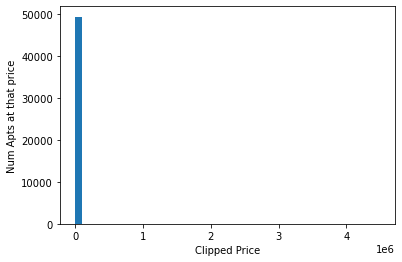

In [118]:
plt.hist(rent_num['price'], bins=45)
plt.xlabel('Clipped Price')
plt.ylabel('Num Apts at that price')

Text(0, 0.5, 'Num Apts at that price')

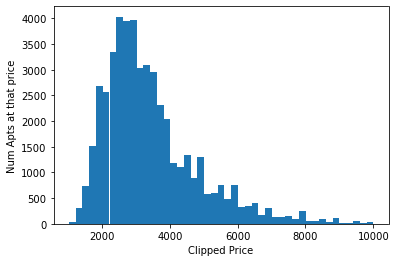

In [109]:
plt.hist(rent_clean['price'], bins=45)
plt.xlabel('Clipped Price')
plt.ylabel('Num Apts at that price')

Text(0, 0.5, 'Num Apts at that price')

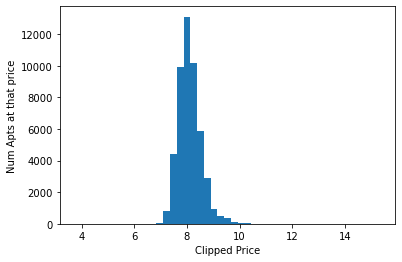

In [110]:
plt.hist(np.log(rent_num['price']), bins=45)
plt.xlabel('Clipped Price')
plt.ylabel('Num Apts at that price')